**In this notebook, data will be combined from various sources and features for audio files will be extracted**

**Importing required Libraries**

In [1]:
#  importing libraries

import librosa
from librosa import display
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**First just let's pick random audio file to see how librosa load works**

In [3]:
#loading data for a random audio file using librosa

data, sampling_rate = librosa.load('/content/drive/MyDrive/Almabetter/audio files/song audio files/Actor_01/03-02-01-01-01-01-01.wav')

In [5]:
#samples taken per second, and by default, librosa samples the file at a sampling rate of 22050; you can override it by your desired sampling rate.

sampling_rate

22050

In [6]:
print(data.shape)
data

(93439,)


array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -1.5206661e-08,  1.1565254e-08,  0.0000000e+00], dtype=float32)

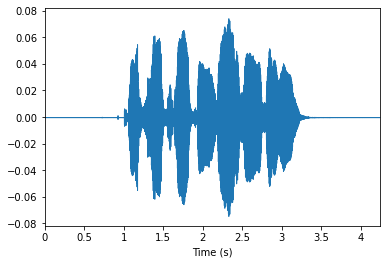

In [7]:
# displaying waveplot
librosa.display.waveplot(data, sampling_rate,x_axis='s')

**Now creating function to perform feature extraction on various audio files and create required dataset**

In [8]:
# function will take audio file path and extract MFCC features(mel frequency cepstral coefficients) for audio data.

def data_load(path,src) :
  data = []
  for subdir,dirs, files in os.walk(path):
    for file in files:    
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        #features extracted for audio file using MFCC
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 

        # using if conditions to create and co-ordinate ravdess data and TESS data labels, so that data can be combined

        if src == "ravdess":          
          label = int(file.split("-")[2]) -1
        else :
          if 'angry' in file:
            label = 'angry'
          elif 'disgust' in file:
            label ='disgust'
          elif 'fear' in file:
            label ='fear'
          elif 'happy' in file:
            label = 'happy'
          elif 'neutral' in file:
            label ='neutral'
          elif 'ps' in file:
            label ='pleasant surprise'
          elif 'sad' in file:
            label ='sad'
          else:
            label = 'NA'  
        arr = mfccs, label
        data.append(arr)
  return data      
 

In [9]:
# loading all the data available using data_load function created above

ravdess_data = data_load('/content/drive/MyDrive/Almabetter/audio files','ravdess')
tess_data = data_load('/content/drive/MyDrive/Almabetter/TESS Toronto emotional speech set data','tess')

In [10]:
#Checking labels for ravdess data first

X_ravdess, y_ravdess = zip(*ravdess_data)
np.unique(y_ravdess)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [11]:
# checking labels for TESS data

X_tess, y_tess = zip(*tess_data)
np.unique(y_tess)

array(['angry', 'disgust', 'fear', 'happy', 'neutral',
       'pleasant surprise', 'sad'], dtype='<U17')

In [12]:
# converting to arrays

X_ravdess = np.asarray(X_ravdess)
y_ravdess = np.asarray(y_ravdess)
X_tess = np.asarray(X_tess)
y_tess = np.asarray(y_tess)

In [13]:
# co-ordinating labels for TESS AND RAVDESS datasets

for i in range(len(y_tess)):
  if y_tess[i] == "angry":
    y_tess[i] = 4
  elif y_tess[i] == "disgust":
    y_tess[i] = 6 
  elif y_tess[i] == "fear":
    y_tess[i] =  5
  elif y_tess[i] ==  "happy":
    y_tess[i]  = 2
  elif y_tess[i] == "neutral":
    y_tess[i]  = 0
  elif y_tess[i] == "pleasant surprise":
    y_tess[i] = 7 
  elif y_tess[i] == "sad":
    y_tess[i] = 3    


In [14]:
# checking the converted labels of TESS data
np.unique(y_tess)

array(['0', '2', '3', '4', '5', '6', '7'], dtype='<U17')

In [15]:
# shape of both datasets
print("Shape  of ravdess data features",X_ravdess.shape)
print("Shape  of ravdess data labels",y_ravdess.shape)
print("Shape  of TESS data features",X_tess.shape)
print("Shape  of TESS data labels",y_tess.shape)

Shape  of ravdess data features (2452, 40)
Shape  of ravdess data labels (2452,)
Shape  of TESS data features (2800, 40)
Shape  of TESS data labels (2800,)


In [16]:
# converting to dataframes and combining both datasets created using TESS and RAVDESS audio files

ravdess_df = pd.DataFrame(X_ravdess)
ravdess_df['emotion'] = y_ravdess
tess_df = pd.DataFrame(X_tess)
tess_df['emotion'] = y_tess
frames = [ravdess_df, tess_df]
final_data = pd.concat(frames)
# Checking final data enteries
final_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,emotion
0,-528.321533,47.173195,2.631435,14.939351,8.193103,3.663567,-9.597747,-4.570041,-3.722132,-5.821703,-2.292573,-4.429954,-3.283939,-0.518842,-1.307410,0.267563,-1.173470,2.301467,-0.126545,4.183552,1.025416,3.447331,-0.049484,3.662800,0.824353,3.799759,1.258937,4.359741,4.169260,6.378294,4.793785,5.910057,1.894006,5.325587,4.023085,5.158941,2.808573,3.295748,1.972312,5.102187,3
1,-527.629700,48.368885,-6.187747,13.242492,-0.472389,-0.627818,-3.048115,-3.785497,-9.572919,-3.596772,4.334416,-5.076773,-0.432555,-0.509276,-3.849936,1.288462,-2.679971,-0.755608,-0.329920,-0.971555,-3.069993,0.393442,-2.234776,1.004092,1.745765,3.829570,-0.207324,4.958931,1.975488,3.811447,3.396231,2.278142,1.447686,2.641157,1.362890,4.007977,0.011719,0.814065,-0.266730,2.210508,4
2,-680.565918,64.908302,17.960472,23.941381,14.328822,12.681093,2.101332,2.055144,-2.576184,3.079970,-0.118392,-2.075078,3.084237,0.505123,3.033683,6.655987,-1.972009,1.578540,3.175197,1.464963,-2.324510,4.109143,-5.340979,-0.224232,-0.164529,2.152969,-0.122371,3.446126,-1.209258,1.155086,-1.828201,-0.164363,-0.278901,1.772694,-1.331633,1.330674,-3.645186,-1.537878,-4.229579,-0.651406,1
3,-555.722290,56.944500,-4.183017,16.818874,4.908437,2.978804,-3.967603,-2.564917,-8.553740,-0.425886,5.742433,-6.308222,1.383288,2.639100,-2.120058,3.112583,-3.274935,0.762563,2.171553,2.242014,-0.945900,0.743926,-2.040370,0.222340,-0.634997,0.792216,-1.776182,2.168432,-1.270737,0.387491,0.488614,-0.859154,0.275535,0.431264,0.120321,3.855029,0.009521,1.464371,-0.419368,1.797345,4
4,-611.765381,54.225819,-3.265942,16.220272,2.916856,0.932325,-7.010364,-7.922600,-5.687799,-2.169403,0.475313,-8.617010,1.024009,0.341207,-4.550450,2.318602,-3.804256,-0.090218,1.350664,-0.109125,-4.298742,-3.061666,-3.760662,-1.612138,-5.048974,0.328476,-3.007545,2.674329,-1.574020,1.139760,2.470630,-1.142443,0.525777,2.377189,-0.883754,3.829534,1.228071,1.932130,0.010801,3.185586,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-432.672028,66.913521,2.102658,-10.062201,-7.043127,2.562237,-16.543615,-1.396074,-17.180323,-3.631984,-14.993348,7.306749,-2.450127,7.189114,3.749081,2.001553,-2.909781,0.431445,-7.576050,-5.154823,-0.682453,3.287864,-0.540352,7.300181,8.904586,16.990376,15.298347,24.849350,13.675763,13.227838,5.336472,8.806970,4.926255,3.264943,5.082578,-0.236321,0.402852,7.349115,0.819480,4.849926,4
2796,-436.879700,50.379658,0.327101,-8.451310,-7.740461,2.572479,-15.255656,-5.330518,-12.318529,2.292882,-14.931806,12.476283,-1.101851,6.176120,4.268865,0.880247,-7.027131,0.288587,-8.072464,-5.235204,-1.008475,-0.871306,-1.951543,13.500531,16.891674,26.000711,23.369299,22.075081,5.856600,4.837675,0.763879,10.301969,8.496471,1.834135,-1.329688,-2.443805,1.814834,12.300548,-0.743078,3.553173,4
2797,-396.690887,63.889370,-9.775565,-11.786915,-7.356016,10.631380,-23.239269,-11.940575,-16.548185,1.004224,-0.469829,3.268285,1.798411,3.376618,1.486295,-0.911262,-6.131103,-0.122601,-5.211834,-10.001427,-5.235061,-0.764327,-6.481869,11.024531,9.308496,25.126148,24.593138,27.542501,15.826229,9.061973,-3.180033,1.913085,7.057357,6.657569,7.823931,-4.028030,0.355843,7.298701,1.777309,2.214736,4
2798,-394.775879,60.945877,-6.951421,-6.920915,2.649036,18.569458,-30.318823,-22.087646,-20.750616,-3.935099,-5.465997,-2.901628,3.288727,1.155707,-2.874482,-1.798038,-8.563427,-1.293230,-6.008198,-7.646235,-5.229954,0.589642,-8.857723,3.823742,4.711602,17.059023,19.203896,28.172707,17.014399,17.348316,6.287297,5.690722,11.673584,5.722743,8.649398,2.147148,3.026187,9.144466,-0.022351,1.693430,4


In [17]:
# shape of processed data created
final_data.shape

(5252, 41)

In [18]:
# saving processed data in a csv file for further use

final_data.to_csv("/content/drive/MyDrive/Almabetter/processed_data")